# Validation of Regressor Implementations 
This is an example script which replicates published results for the MC-dropout, Deep Ensemble, and Split Conformal Quantile Regression (CQR) methods. Additionally, average coverage is validated for the K-fold-CQR and normalized conformal ensemble methods. This script matches the experimental setup described in each of these papers using public datasets, runs one fit-predict trial, and verifies that the desired results land within the probable range reported in the published results. 

## Utility functions for running regressor tests:

In [5]:
import numpy as np 
import torch 
from uqregressors.utils.torch_sklearn_utils import train_test_split
from uqregressors.tuning.tuning import tune_hyperparams, log_likelihood
from uqregressors.utils.logging import set_logging_config
from uqregressors.utils.file_manager import FileManager
from uqregressors.bayesian.dropout import MCDropoutRegressor
from uqregressors.bayesian.deep_ens import DeepEnsembleRegressor
from uqregressors.utils.data_loader import clean_dataset, validate_dataset
from uqregressors.metrics.metrics import compute_all_metrics
from uqregressors.utils.data_loader import load_unformatted_dataset
from uqregressors.conformal.cqr import ConformalQuantileRegressor
from uqregressors.conformal.k_fold_cqr import KFoldCQR
from uqregressors.conformal.conformal_ens import ConformalEnsRegressor
from pathlib import Path
from copy import deepcopy
import optuna
device = "cuda" if torch.cuda.is_available() else "cpu"

r_seed = 42
set_logging_config(print=False) # Disable logging for all future regressors for cleanliness
optuna.logging.set_verbosity(optuna.logging.WARNING) # Disable hyperparameter logging for cleanliness

def test_regressor(model, X, y, dataset_name, test_size, seed=None, 
                   tuning_epochs=None, param_space=None, scoring_fn=None, greater=None,
                   initial_params=None, n_trials=None, n_splits=1): 
    if seed is not None: 
        np.random.seed(seed)
        torch.manual_seed(seed)

    X, y = clean_dataset(X, y)
    validate_dataset(X, y, name=dataset_name)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    # Hyperparameter Optimization: 
    if tuning_epochs is not None and param_space is not None: 
        epochs_copy = model.epochs
        model.epochs = deepcopy(tuning_epochs)
        opt_model, opt_score, study = tune_hyperparams(regressor=model, 
                                                        param_space=param_space,
                                                        X=X_train, 
                                                        y=y_train,
                                                        score_fn=scoring_fn, 
                                                        greater_is_better=greater,
                                                        initial_params=initial_params, 
                                                        n_trials=n_trials, 
                                                        n_splits=n_splits, 
                                                        verbose=False
                                                        )
        model = opt_model 
        model.epochs = epochs_copy 
        
    # Modify learning rate for deep ensembles on energy and kin8nm datasets: 
    if type(model) is DeepEnsembleRegressor: 
        print (type(model))
        if dataset_name in ["energy", "kin8nm"]: 
            print("Setting learning rate to 1e-2")
            model.learning_rate = 1e-2 

        else: 
            print ("Setting learning rate to 1e-1")
            model.learning_rate =1e-1

    model.fit(X_train, y_train)
    mean, lower, upper = model.predict(X_test)

    metrics = compute_all_metrics(mean, lower, upper, y_test, model.alpha)
    metrics["scale_factor"] = np.mean(np.abs(y)).astype(np.float64)

    return metrics 

def run_regressor_test(model, datasets, seed, filename, test_size, 
                       BASE_SAVE_DIR=Path.home()/".uqregressors", 
                       tuning_epochs=None, param_space=None, scoring_fn=None, greater=None, 
                       initial_params=None, n_trials=None, n_splits=1): 
    DATASET_PATH = Path.cwd().absolute() / "datasets"
    saved_results = []
    for name, file in datasets.items(): 
        print(f"\n Loading dataset: {name}")
        X, y = load_unformatted_dataset(DATASET_PATH / file)

        metrics = test_regressor(model, X, y, name, seed=seed, test_size=test_size, 
                                 tuning_epochs=tuning_epochs, param_space=param_space, 
                                 scoring_fn=scoring_fn, greater=greater, initial_params=initial_params, 
                                 n_trials=n_trials, n_splits=n_splits)
        print(metrics)

        fm = FileManager(BASE_SAVE_DIR)
        save_path = fm.save_model(model, name=name + "_" + filename, metrics=metrics)
        saved_results.append((model.__class__, name, save_path))
    return saved_results

def print_results(paths): 
    fm = FileManager()
    for cls, dataset_name, path in paths: 
        results = fm.load_model(cls, path=path, load_logs=False)
        print (f"Results for {dataset_name}")
        print(results["metrics"])

## Datasets 
A variety of datasets are chosen which match the datasets for which there are published results. Extremely large datasets, and those where there is ambiguity about which target is being predicted are omitted. 

Information about the datasets used is available in: [Hernández Lobato and Adams, 2015](https://arxiv.org/abs/1502.05336).

In [6]:
datasets_bayesian = { 
    "concrete": "concrete.xls", 
    "energy": "energy_efficiency.xlsx", 
    "kin8nm": "kin8nm.arff", 
    "power": "power_plant.xlsx", 
    "wine": "winequality-red.csv", 
}

datasets_conformal = {
    "concrete": "concrete.xls",
    "protein": "protein_structure.csv"
}

In [7]:
import matplotlib.pyplot as plt 
import numpy as np 

def plot_validation(pub, save_paths, name, metric_1, metric_2, metric_1_name, metric_2_name): 
    save_paths_dict = dict(zip([path[1] for path in save_paths], [(path[0], path[2]) for path in save_paths]))

    MCD_exp = {}
    fm = FileManager()
    for key, (RMSE, RMSE_std, LL, LL_std) in pub.items(): 
        MCD_exp[key] = fm.load_model(model_class=save_paths_dict[key][0], path=save_paths_dict[key][1])["metrics"]
        
    datasets = list(pub.keys())
    datasets.reverse()
    y_pos = np.arange(len(datasets))

    # Prepare RMSE and LL values
    pub_rmse = np.array([pub[d][0] for d in datasets])
    pub_rmse_err = np.array([1.96 * pub[d][1] for d in datasets])
    exp_rmse = np.array([MCD_exp[d][metric_1] for d in datasets])

    pub_ll = np.array([pub[d][2] for d in datasets])
    pub_ll_err = np.array([1.96 * pub[d][3] for d in datasets])
    if metric_2 is "nll_gaussian": 
        exp_ll = np.array([-MCD_exp[d][metric_2] for d in datasets])
    else: 
        exp_ll = np.array([MCD_exp[d][metric_2] for d in datasets])

    # Plot RMSE
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.errorbar(pub_rmse, y_pos, xerr=pub_rmse_err, fmt='o', label='Published (95% CI)', color='blue', capsize=6)
    ax.scatter(exp_rmse, y_pos, color='red', label='Experimental', zorder=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(datasets)
    ax.set_xlabel(metric_1_name)
    ax.set_title(f"{name}: {metric_1_name} Validation")
    ax.legend()
    ax.grid(True)

    # Plot Log Likelihood
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    ax2.errorbar(pub_ll, y_pos, xerr=pub_ll_err, fmt='o', label='Published (95% CI)', color='blue', capsize=6)
    ax2.scatter(exp_ll, y_pos, color='red', label='Experimental', zorder=5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(datasets)
    ax2.set_xlabel(metric_2_name)
    ax2.set_title(f"{name}: {metric_2_name} Validation")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

## MC dropout Regressor 
First, results are generated and compared to the results published in [Gal and Ghahramani, 2016](https://arxiv.org/pdf/1506.02142). As described in the paper, a single layer neural network with 50 hidden units is used with 0.05 dropout probability, and parameters optimized for 400 epochs with minibatch sizes of 32 on the Adam optimizer. Before training, the aleatoric uncertainty parameter, $\tau$, is estimated with 30 iterations of Bayesian Optimization with initial prior length scale 0.01. 

In [ ]:
from uqregressors.tuning.tuning import log_likelihood, interval_score


dropout = MCDropoutRegressor(
    hidden_sizes = [50], 
    dropout=0.05, 
    use_paper_weight_decay=True, 
    prior_length_scale=1e-2,
    alpha=0.05, 
    n_samples=100, 
    epochs=400, # Changed to 40 during hyperparameter tuning
    batch_size=32, 
    learning_rate=1e-3, 
    device=device, 
    use_wandb=False
)

# Hyperparameter Tuning: 
param_space = {
    "tau": lambda trial: trial.suggest_float("tau", 1e-2, 1e2, log=True)
}

MC_save_paths = run_regressor_test(dropout, datasets_bayesian, seed=r_seed, filename="dropout_validation", test_size=0.2, 
                   tuning_epochs=40, param_space=param_space, scoring_fn=log_likelihood, greater=True, n_trials=40)

print_results(MC_save_paths)


 Loading dataset: concrete
Summary for: concrete dataset
Number of samples: 1030
Number of features: 8
Output shape: (1030, 1)
Dataset validation passed.



  0%|          | 0/40 [00:00<?, ?it/s]

{'rmse': np.float64(4.588262381833446), 'coverage': np.float64(0.9854368932038835), 'average_interval_width': np.float64(26.949054310622724), 'interval_score': np.float64(27.265795772515453), 'nll_gaussian': np.float64(3.0689444284791594), 'error_width_corr': np.float64(0.007090388758835557), 'RMSCD': np.float64(0.04183977645045489), 'RMSCD_under': 0.0, 'lowest_group_coverage': np.float64(0.95), 'scale_factor': np.float64(35.81783676147461)}
Model and additional artifacts saved to: C:\Users\arsha\.uqregressors\models\concrete_dropout_validation

 Loading dataset: energy
Summary for: energy dataset
Number of samples: 768
Number of features: 9
Output shape: (768, 1)
Dataset validation passed.



  0%|          | 0/40 [00:00<?, ?it/s]

{'rmse': np.float64(1.8154151396435967), 'coverage': np.float64(0.9934640522875817), 'average_interval_width': np.float64(9.292824944639518), 'interval_score': np.float64(9.29605581869487), 'nll_gaussian': np.float64(2.0713367590672997), 'error_width_corr': np.float64(0.16627962506319155), 'RMSCD': np.float64(0.04772607021092122), 'RMSCD_under': np.float64(0.016666666666666607), 'lowest_group_coverage': np.float64(0.9333333333333333), 'scale_factor': np.float64(24.58776092529297)}
Model and additional artifacts saved to: C:\Users\arsha\.uqregressors\models\energy_dropout_validation

 Loading dataset: kin8nm
Summary for: kin8nm dataset
Number of samples: 8192
Number of features: 8
Output shape: (8192, 1)
Dataset validation passed.



  0%|          | 0/40 [00:00<?, ?it/s]

{'rmse': np.float64(0.09964936284927994), 'coverage': np.float64(0.9352869352869353), 'average_interval_width': np.float64(0.36604641983797265), 'interval_score': np.float64(0.3774666080890412), 'nll_gaussian': np.float64(-0.9282787565591294), 'error_width_corr': np.float64(0.2727166245830174), 'RMSCD': np.float64(0.05378532742082101), 'RMSCD_under': np.float64(0.07309063821116123), 'lowest_group_coverage': np.float64(0.7987804878048781), 'scale_factor': np.float64(0.7142835259437561)}
Model and additional artifacts saved to: C:\Users\arsha\.uqregressors\models\kin8nm_dropout_validation

 Loading dataset: power
Summary for: power dataset
Number of samples: 9568
Number of features: 4
Output shape: (9568, 1)
Dataset validation passed.



  0%|          | 0/40 [00:00<?, ?it/s]

{'rmse': np.float64(3.9932890859700856), 'coverage': np.float64(0.9200209095661265), 'average_interval_width': np.float64(13.52532780313766), 'interval_score': np.float64(14.21172234255546), 'nll_gaussian': np.float64(2.8291955522306482), 'error_width_corr': np.float64(0.007991256770224575), 'RMSCD': np.float64(0.046949003316637955), 'RMSCD_under': np.float64(0.05050914848738009), 'lowest_group_coverage': np.float64(0.8586387434554974), 'scale_factor': np.float64(454.3650207519531)}
Model and additional artifacts saved to: C:\Users\arsha\.uqregressors\models\power_dropout_validation

 Loading dataset: wine
Summary for: wine dataset
Number of samples: 1599
Number of features: 11
Output shape: (1599, 1)
Dataset validation passed.



  0%|          | 0/40 [00:00<?, ?it/s]

{'rmse': np.float64(0.6180300723606387), 'coverage': np.float64(0.9467084639498433), 'average_interval_width': np.float64(2.5444983434527644), 'interval_score': np.float64(2.615172450445289), 'nll_gaussian': np.float64(0.9388280746610236), 'error_width_corr': np.float64(0.10816658057447093), 'RMSCD': np.float64(0.0817773349908775), 'RMSCD_under': np.float64(0.13640703510951083), 'lowest_group_coverage': np.float64(0.71875), 'scale_factor': np.float64(5.636022567749023)}
Model and additional artifacts saved to: C:\Users\arsha\.uqregressors\models\wine_dropout_validation

 Loading dataset: yacht
Summary for: yacht dataset
Number of samples: 308
Number of features: 6
Output shape: (308, 1)
Dataset validation passed.



  0%|          | 0/40 [00:00<?, ?it/s]

{'rmse': np.float64(5.890747898778732), 'coverage': np.float64(0.9836065573770492), 'average_interval_width': np.float64(27.95698383987927), 'interval_score': np.float64(28.290501446020407), 'nll_gaussian': np.float64(3.222766751055446), 'error_width_corr': np.float64(0.24478048855036813), 'RMSCD': np.float64(0.06009252125773318), 'RMSCD_under': np.float64(0.11666666666666659), 'lowest_group_coverage': np.float64(0.8333333333333334), 'scale_factor': np.float64(10.495357513427734)}
Model and additional artifacts saved to: C:\Users\arsha\.uqregressors\models\yacht_dropout_validation
Results for concrete
{'rmse': 4.588262381833446, 'coverage': 0.9854368932038835, 'average_interval_width': 26.949054310622724, 'interval_score': 27.265795772515453, 'nll_gaussian': 3.0689444284791594, 'error_width_corr': 0.007090388758835557, 'RMSCD': 0.04183977645045489, 'RMSCD_under': 0.0, 'lowest_group_coverage': 0.95, 'scale_factor': 35.81783676147461}
Results for energy
{'rmse': 1.8154151396435967, 'cove

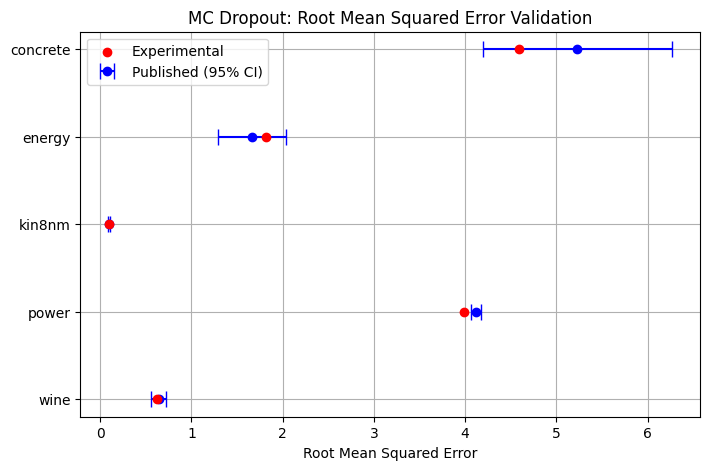

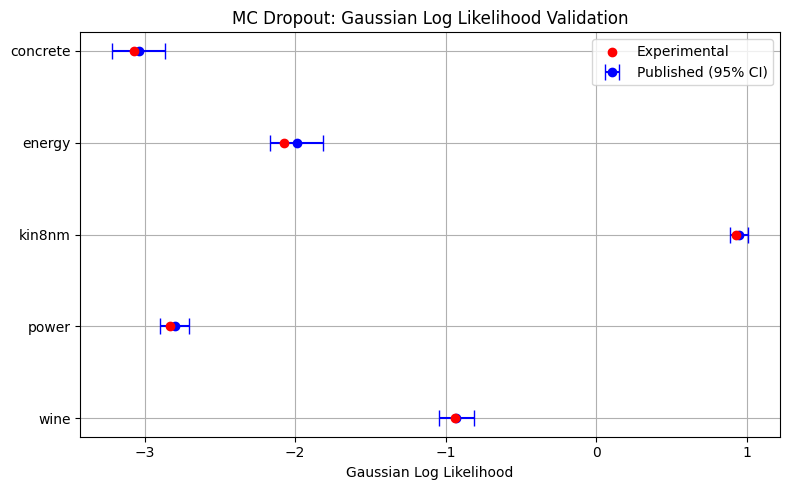

In [38]:
MCD_pub = {
    "concrete": [5.23, 0.53, -3.04, 0.09], 
    "energy": [1.66, 0.19, -1.99, 0.09], 
    "kin8nm": [0.1, 0.005, 0.95, 0.03], 
    "power": [4.12, 0.03, -2.80, 0.05], 
    "wine": [0.64, 0.04, -0.93, 0.06]
}
plot_validation(MCD_pub, MC_save_paths, "MC Dropout", "rmse", "nll_gaussian", "Root Mean Squared Error", "Gaussian Log Likelihood")

## Deep Ensemble Regressor 
Next, validation is performed for the Deep Ensemble Regressor as in [Lakshminarayanan et. al. 2017](https://arxiv.org/pdf/1612.01474). A very similar experimental setup as that of MC Dropout is carried out using a Deep Ensemble with 5 estimators, each a single layer neural network with 50 hidden units, a batch size of 100, and a learning rate of either 1e-1 or 1e-2 on the Adam optimizer. 

In [ ]:
deep_ens = DeepEnsembleRegressor(
    n_estimators=5, 
    hidden_sizes=[50], 
    n_jobs=2, 
    alpha=0.05, 
    batch_size=100, 
    learning_rate=1e-1, #Changed to 1e-2 for energy and kin8nm datasets 
    epochs=40, 
    device=device, 
    scale_data=True, 
    use_wandb=False
)

deep_ens_save_paths = run_regressor_test(deep_ens, datasets_bayesian, seed=r_seed, filename="deep_ens_validation", test_size=0.1)


 Loading dataset: concrete
Summary for: concrete dataset
Number of samples: 1030
Number of features: 8
Output shape: (1030, 1)
Dataset validation passed.

<class 'uqregressors.bayesian.deep_ens.DeepEnsembleRegressor'>
Setting learning rate to 1e-1
{'rmse': np.float64(5.770383232717203), 'coverage': np.float64(0.9611650485436893), 'average_interval_width': np.float64(29.67108839460947), 'interval_score': np.float64(30.34469082286057), 'nll_gaussian': np.float64(3.189734210487027), 'error_width_corr': np.float64(0.3009757177966646), 'RMSCD': np.float64(0.05), 'RMSCD_under': np.float64(0.04999999999999993), 'lowest_group_coverage': np.float64(0.9), 'scale_factor': np.float64(35.81783676147461)}
Model and additional artifacts saved to: C:\Users\arsha\.uqregressors\models\concrete_deep_ens_validation

 Loading dataset: energy
Summary for: energy dataset
Number of samples: 768
Number of features: 9
Output shape: (768, 1)
Dataset validation passed.

<class 'uqregressors.bayesian.deep_ens.Dee

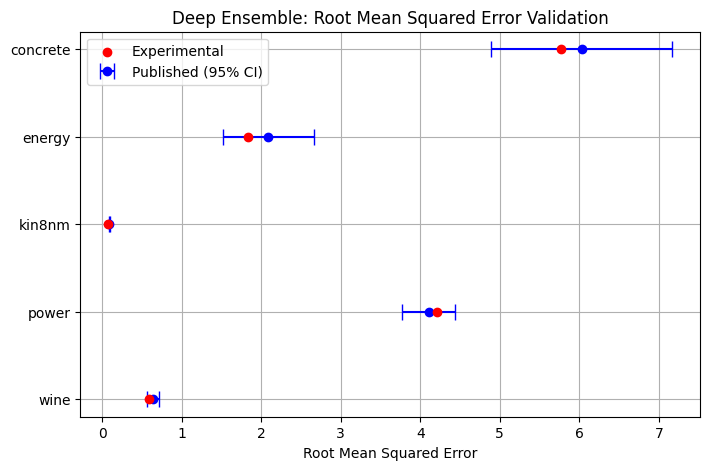

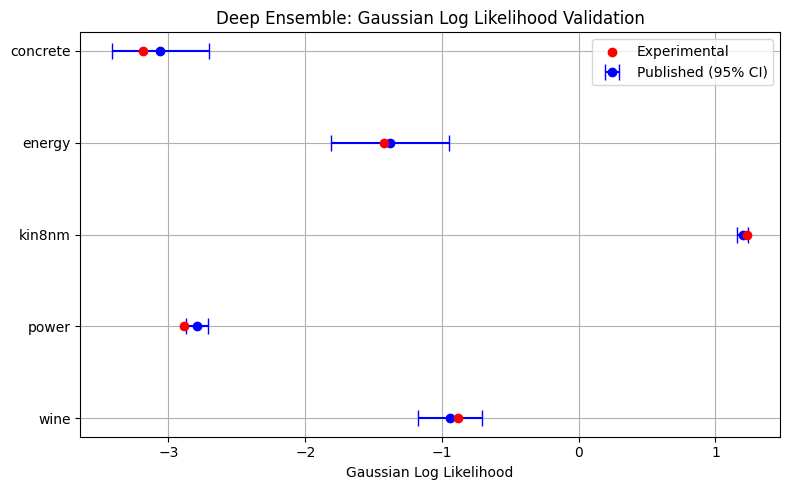

In [39]:
DE_pub = {
    "concrete": [6.03, 0.58, -3.06, 0.18], 
    "energy": [2.09, 0.29, -1.38, 0.22], 
    "kin8nm": [0.09, 0.005, 1.2, 0.02], 
    "power": [4.11, 0.17, -2.79, 0.04], 
    "wine": [0.64, 0.04, -0.94, 0.12]
}
plot_validation(DE_pub, deep_ens_save_paths, "Deep Ensemble", "rmse", "nll_gaussian", "Root Mean Squared Error", "Gaussian Log Likelihood")

## Split Conformal Prediction
Next, split conformal prediction is validated according to the results in [Romano et. al. 2019](https://arxiv.org/abs/1905.03222). A split conformal quantile regressor with half of the training data in the calibration set, two hidden layers of 64 neurons each, a 0.1 dropout probability, and trained for 1000 epochs with a batch size of 64 using the standard quantile loss function is implemented as in the paper, and compared to the published results. 

In [ ]:
from uqregressors.tuning.tuning import interval_width
cqr = ConformalQuantileRegressor(
    hidden_sizes=[64, 64], 
    cal_size = 0.5, 
    alpha=0.1, 
    dropout=0.1, 
    epochs=1000, 
    batch_size=64, 
    learning_rate=5e-4, 
    optimizer_kwargs = {"weight_decay": 1e-6}, 
    device=device, 
    scale_data=True, 
    use_wandb=False
)

param_space = {
    "tau_lo": lambda trial: trial.suggest_float("tau_lo", 0.03, 0.1),
    "tau_hi": lambda trial: trial.suggest_float("tau_hi", 0.9, 0.97) 
}

cqr_save_paths = run_regressor_test(cqr, datasets_conformal, seed=r_seed, filename="cqr_validation", test_size=0.2, 
                                    tuning_epochs=500, param_space=param_space, scoring_fn=interval_width, greater=False, 
                                    n_trials=10, n_splits=3)


 Loading dataset: concrete
Summary for: concrete dataset
Number of samples: 1030
Number of features: 8
Output shape: (1030, 1)
Dataset validation passed.



  0%|          | 0/10 [00:00<?, ?it/s]

{'rmse': np.float64(5.6448431465607625), 'coverage': np.float64(0.9029126213592233), 'average_interval_width': np.float64(17.26022766631784), 'interval_score': np.float64(18.733263941644466), 'nll_gaussian': np.float64(3.1728281903275146), 'error_width_corr': np.float64(0.2196118597273525), 'RMSCD': np.float64(0.06184979244425017), 'RMSCD_under': np.float64(0.04656573146573326), 'lowest_group_coverage': np.float64(0.85), 'scale_factor': np.float64(35.81783676147461)}
Model and additional artifacts saved to: C:\Users\arsha\.uqregressors\models\concrete_cqr_validation

 Loading dataset: protein
Summary for: protein dataset
Number of samples: 45730
Number of features: 9
Output shape: (45730, 1)
Dataset validation passed.



  0%|          | 0/10 [00:00<?, ?it/s]